In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers

%matplotlib notebook

Using TensorFlow backend.


# Preprocessing Data

In [2]:
df = pd.read_csv('data/skeleton_filtered.csv')

df

,nose_x,nose_y,neck_x,neck_y,Rshoulder_x,Rshoulder_y,Relbow_x,Relbow_y,Rwrist_x,RWrist_y,...,LAnkle_y,REye_x,REye_y,LEye_x,LEye_y,REar_x,REar_y,LEar_x,LEar_y,class
0,0.643519,0.157609,0.634259,0.250000,0.587963,0.244565,0.555556,0.342391,0.550926,0.434783,...,0.755435,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
1,0.643519,0.157609,0.634259,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.766304,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
2,0.643519,0.157609,0.638889,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.760870,0.634259,0.146739,0.652778,0.146739,0.615741,0.157609,0.671296,0.152174,kick
3,0.643519,0.157609,0.638889,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.755435,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
4,0.643519,0.157609,0.638889,0.250000,0.587963,0.244565,0.560185,0.342391,0.555556,0.429348,...,0.760870,0.629630,0.146739,0.652778,0.146739,0.615741,0.157609,0.666667,0.152174,kick
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3219,0.587963,0.152174,0.587963,0.233696,0.541667,0.217391,0.500000,0.163043,0.486111,0.092391,...,0.755435,0.578704,0.141304,0.597222,0.141304,0.564815,0.152174,0.620370,0.146739,wave
3220,0.583333,0.157609,0.587963,0.233696,0.541667,0.222826,0.490741,0.179348,0.458333,0.114130,...,0.755435,0.574074,0.141304,0.597222,0.141304,0.564815,0.152174,0.615741,0.146739,wave
3221,0.583333,0.157609,0.587963,0.228261,0.537037,0.222826,0.481481,0.179348,0.439815,0.108696,...,0.755435,0.574074,0.141304,0.000000,0.000000,0.560185,0.146739,0.615741,0.146739,wave
3222,0.578704,0.157609,0.583333,0.228261,0.532407,0.222826,0.476852,0.184783,0.421296,0.125000,...,0.755435,0.569444,0.146739,0.592593,0.141304,0.560185,0.152174,0.611111,0.146739,wave


In [3]:
# activity = df['class'].drop_duplicates().to_list()
activity = ['kick', 'stand', 'wave']

activity

['kick', 'stand', 'wave']

In [4]:
unique, counts = np.unique(df['class'], return_counts=True)
itemfreq = np.vstack((unique, counts)).T

itemfreq

array([['kick', 525],
       ['punch', 438],
       ['squat', 571],
       ['stand', 861],
       ['wave', 829]], dtype=object)

In [5]:
X_2d = df.iloc[:,:-1].to_numpy()
X_2d.shape

(3224, 36)

In [6]:
y_2d = df['class'].to_numpy()

y_2d.shape

(3224,)

In [7]:
label_2d = LabelEncoder().fit_transform(y_2d)

In [8]:
train_size = 0.8
test_size = 0.2
random_state = 0
X_2d_train_temp, X_2d_test, y_2d_train_temp, y_2d_test = train_test_split(X_2d, label_2d, train_size=train_size, test_size=test_size, random_state=random_state, stratify=label_2d)

train_size_temp = 0.5
validate_size = 0.5
X_2d_train, X_2d_validate, y_2d_train, y_2d_validate = train_test_split(X_2d_train_temp, y_2d_train_temp, train_size=train_size_temp, test_size=validate_size, random_state=random_state, stratify=y_2d_train_temp)

X_2d_train.shape, X_2d_validate.shape, X_2d_test.shape, y_2d_train.shape, y_2d_validate.shape, y_2d_test.shape

((1289, 36), (1290, 36), (645, 36), (1289,), (1290,), (645,))

In [9]:
def process_create_WindowTimeSeries(activity, df, activity_start, activity_len, time_window, n_feature, step_stride):
    df_series = df[df['class'] == activity].iloc[:,:-1][activity_start:(activity_start+activity_len)]
    segments = []
    labels = []

    for i in range(0, df_series.shape[0] - time_window, step_stride):
        df_series_feature = df_series.iloc[i: i + time_window]
        segments.append(df_series_feature.to_numpy())

    segments = np.asarray(segments)
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_window, n_feature)

    labels = np.repeat(activity, reshaped_segments.shape[0])

    return reshaped_segments, labels

In [10]:
activity_start = 0
activity_len = df.shape[0]
time_window = 100
n_feature = len(activity)
step_stride = 10

X_3d = []
y_3d = []

for i in activity:
    reshaped_segments, labels = process_create_WindowTimeSeries(i, df, activity_start, activity_len, time_window, n_feature, step_stride)
    X_3d.append(reshaped_segments)
    y_3d.append(labels)
    
X_3d = np.concatenate(X_3d)
y_3d = np.concatenate(y_3d)

X_3d.shape, y_3d.shape

((2316, 100, 3), (2316,))

In [11]:
label_3d = LabelEncoder().fit_transform(y_3d)

onehot_3d = np.zeros((label_3d.shape[0], len(activity)))
onehot_3d[np.arange(label_3d.shape[0]), label_3d] = 1

In [12]:
X_3d_train_temp, X_3d_test, y_3d_train_temp, y_3d_test = train_test_split(X_3d, onehot_3d, train_size=train_size, test_size=test_size, random_state=random_state, stratify=onehot_3d)
X_3d_train, X_3d_validate, y_3d_train, y_3d_validate = train_test_split(X_3d_train_temp, y_3d_train_temp, train_size=train_size_temp, test_size=validate_size, random_state=random_state, stratify=y_3d_train_temp)

X_3d_train.shape, X_3d_validate.shape, X_3d_test.shape, y_3d_train.shape, y_3d_validate.shape, y_3d_test.shape

((926, 100, 3), (926, 100, 3), (464, 100, 3), (926, 3), (926, 3), (464, 3))

# SVC

In [13]:
k = 10
seed = random_state

skfold = StratifiedKFold(n_splits=k, shuffle=True, random_state=seed)

In [14]:
c_val = 100
gmm = 0.1

SVC_lin = SVC(kernel='linear', C=c_val)
SVC_rbf = SVC(kernel='rbf', C=c_val, gamma=gmm)

In [15]:
score_lin = cross_val_score(SVC_lin, X_2d_train, y_2d_train, cv=skfold)
score_rbf = cross_val_score(SVC_rbf, X_2d_train, y_2d_train, cv=skfold)

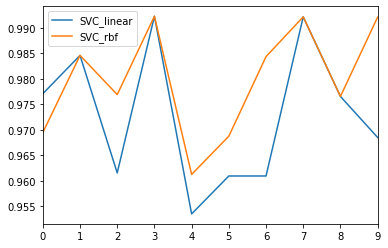

In [16]:
score_all = pd.DataFrame({'SVC_linear':score_lin, 'SVC_rbf': score_rbf })
score_all.plot()

In [17]:
lin_pred = SVC_lin.fit(X_2d_train, y_2d_train).predict(X_2d_validate)
rbf_pred = SVC_rbf.fit(X_2d_train, y_2d_train).predict(X_2d_validate)

In [18]:
print(classification_report(y_2d_validate, lin_pred))
print(classification_report(y_2d_validate, rbf_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       0.97      0.86      0.91       175
           2       1.00      1.00      1.00       228
           3       1.00      1.00      1.00       345
           4       0.93      0.98      0.96       332

    accuracy                           0.98      1290
   macro avg       0.98      0.97      0.97      1290
weighted avg       0.98      0.98      0.97      1290

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       210
           1       0.97      0.89      0.93       175
           2       1.00      1.00      1.00       228
           3       1.00      1.00      1.00       345
           4       0.94      0.99      0.96       332

    accuracy                           0.98      1290
   macro avg       0.98      0.97      0.98      1290
weighted avg       0.98      0.98      0.98      1290



In [19]:
print(confusion_matrix(y_2d_validate, lin_pred))
print(confusion_matrix(y_2d_validate, rbf_pred))

[[209   0   0   1   0]
 [  0 150   0   0  25]
 [  0   0 228   0   0]
 [  1   0   0 344   0]
 [  0   5   0   0 327]]
[[209   0   0   1   0]
 [  0 155   0   0  20]
 [  0   0 228   0   0]
 [  0   0   0 345   0]
 [  0   4   0   0 328]]


In [20]:
lin_pred = SVC_lin.fit(X_2d_train, y_2d_train).predict(X_2d_test)
rbf_pred = SVC_rbf.fit(X_2d_train, y_2d_train).predict(X_2d_test)

In [21]:
print(classification_report(y_2d_test, lin_pred))
print(classification_report(y_2d_test, rbf_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.94      0.76      0.84        88
           2       1.00      1.00      1.00       114
           3       0.99      1.00      1.00       172
           4       0.89      0.98      0.93       166

    accuracy                           0.96       645
   macro avg       0.96      0.95      0.95       645
weighted avg       0.96      0.96      0.96       645

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       105
           1       0.97      0.78      0.87        88
           2       1.00      1.00      1.00       114
           3       0.99      1.00      1.00       172
           4       0.90      0.99      0.94       166

    accuracy                           0.97       645
   macro avg       0.97      0.95      0.96       645
weighted avg       0.97      0.97      0.96       645



In [22]:
print(confusion_matrix(y_2d_test, lin_pred))
print(confusion_matrix(y_2d_test, rbf_pred))

[[104   0   0   1   0]
 [  0  67   0   0  21]
 [  0   0 114   0   0]
 [  0   0   0 172   0]
 [  0   4   0   0 162]]
[[104   0   0   1   0]
 [  0  69   0   0  19]
 [  0   0 114   0   0]
 [  0   0   0 172   0]
 [  0   2   0   0 164]]


# CNN

In [23]:
mlp = MLPClassifier(hidden_layer_sizes=(30,30,30), max_iter=500, solver='sgd')

In [24]:


model = Sequential()

model.add(Conv2D(CNN_L1, kernel_size=Ker_size, activation=Act_func, input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(0.2))

model.add(Conv2D(CNN_L,n kernel_size=Ker_size, activation=Act_func,input_shape=Input_shape,padding='same'))
model.add(MaxPooling2D(pool_size=P_size))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dense(Dense_size , activation= Act_func ))
model.add(Dense(#output_class, activation='sigmoid'))
model.compile(loss='categorical_crossentropy',
optimizer=optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999,
amsgrad=False), metrics=['accuracy'])

SyntaxError: invalid syntax (<ipython-input-24-18cf30b86410>, line 7)

In [ ]:
mlp.fit(X_train, y_train)

In [ ]:
mlp_pred = mlp.predict(X_test)

In [ ]:
model.summary()
history = model.fit(X_train,y_train, epochs=#Ep,batch_size=#Bs, validation_data=(X_test,y_test), verbose=1)

In [ ]:
cnn_pred = model.predict(X_test)
cnn_pred_single = [np.argmax(p) for p in cnn_pred]
y_test_single = [np.argmax(p) for p in y_test]

In [ ]:
classification_report(y_test, mlp_pred)

In [ ]:
classification_report(y_test_single, cnn_pred_single)

In [ ]:
confusion_matrix(y_test, mlp_pred)

In [ ]:
confusion_matrix(y_test_single, cnn_pred_single)

# Tune Paraameter